# Test and CrossValidate

In [1]:
import os
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

## Load data

In [2]:
%%capture
# create temporary data folder and download data
!rm -r tmp-data
!mkdir tmp-data
!wget -P tmp-data https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/air_passengers.csv
os.listdir('tmp-data')

In [3]:
air_passengers_df = pd.read_csv(os.path.join('tmp-data', 'air_passengers.csv'))

# 1 Validation using in-built utils
## 1.1 Train Test Validation

In [4]:
m = NeuralProphet(seasonality_mode= "multiplicative", learning_rate = 0.1)

df = pd.read_csv(os.path.join('tmp-data', 'air_passengers.csv'))
df_train, df_val = m.split_df(df=df, freq="MS", valid_p=0.2)

metrics_train = m.fit(df=df_train, freq="MS")
metrics_val = m.test(df=df_val)

# metrics_train
metrics_val

,SmoothL1Loss,MAE,MSE
0,0.005525,27.48901,1117.380005


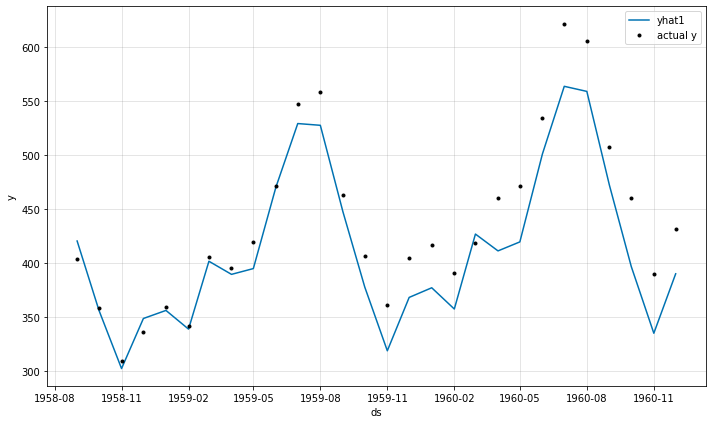

In [5]:
future = m.make_future_dataframe(df_train, periods=len(df_val))
forecast = m.predict(future)
forecast['y'] = df_val['y']
fig = m.plot(forecast)

## 1.2 CrossValidation

In [6]:
METRICS = ['SmoothL1Loss', 'MAE', 'MSE']
params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

df = pd.read_csv(os.path.join('tmp-data', 'air_passengers.csv'))
folds = NeuralProphet(**params).crossvalidation_split_df(df, freq="MS", k=5, fold_pct=0.1)

In [7]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_val = pd.DataFrame(columns=METRICS)

for df_train, df_val in folds:
    m = NeuralProphet(**params)
    train = m.fit(df=df_train, freq="MS")
    val = m.test(df=df_val)
    metrics_train = metrics_train.append(train[METRICS].iloc[-1])
    metrics_val = metrics_val.append(val[METRICS].iloc[-1])

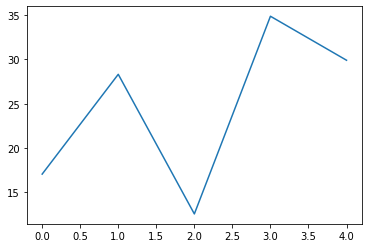

In [8]:
# metrics_train.reset_index(drop=True)
plt = metrics_val.reset_index(drop=True)["MAE"].plot()

In [9]:
metrics_val.describe().loc[["mean", "std", "min", "max"]]

,SmoothL1Loss,MAE,MSE
mean,0.004310,24.537943,819.682211
std,0.002458,9.360669,491.776868
min,0.001260,12.537123,254.827530
max,0.007958,34.884541,1519.619263


# 2 Using Benchmark Framework
Note: The Benchmarking Framework does currently not properly support auto-regression or lagged covariates with multiple step ahead forecasts.

In [10]:
from neuralprophet.benchmark import Dataset, NeuralProphetModel, SimpleExperiment, CrossValidationExperiment
from neuralprophet.benchmark import SimpleBenchmark, CrossValidationBenchmark

## 2.1 SimpleExperiment
Let's set up a train test experiment:

In [11]:
ts = Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp = SimpleExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MAE", "MSE"],
    test_percentage=25,
)
result_train, result_val = exp.fit()

  0%|          | 0/203 [00:00<?, ?it/s]

In [12]:
# result_train
result_val

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MAE': 24.71564483642578,
 'MSE': 837.8035278320312}

## 2.2 CrossValidationExperiment
Let's crossvalidate:

In [13]:
ts = Dataset(df = air_passengers_df, name = "air_passengers", freq = "MS")
params = {"seasonality_mode": "multiplicative"}
exp_cv = CrossValidationExperiment(
    model_class=NeuralProphetModel,
    params=params,
    data=ts,
    metrics=["MAE", "MSE"],
    test_percentage=10,
    num_folds=3,
    fold_overlap_pct=0,
  )
result_train, result_val = exp_cv.fit()

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

In [14]:
result_val

{'data': 'air_passengers',
 'model': 'NeuralProphet',
 'params': "{'seasonality_mode': 'multiplicative'}",
 'MAE': [16.747669219970703, 13.212799072265625, 28.872638702392578],
 'MSE': [439.8111877441406, 276.1831359863281, 892.7733154296875]}

In [15]:
# remove temporary data folder.
!rm -r tmp-data